Nama : Nur Azka Rahadiansyah

NRP : 5027221064

# Soal 1

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import classification_report
from sklearn.model_selection import StratifiedKFold
from scipy.stats import zscore
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

In [4]:
train_df = pd.read_csv("train.csv")
predict_df = pd.read_csv("test.csv")

In [5]:
def label_encode_columns(df, columns):
    encoder = LabelEncoder()
    for column in columns:
        df[column] = encoder.fit_transform(df[column])
    return df

columns_to_encode_train = ['Perjalanan_Bisnis', 'Departemen', 'Bidang_Pendidikan', 'Jenis_Kelamin', 'Peran_Pekerjaan', 'Status_Perkawinan', 'Lembur', 'Atrisi']
train_df = label_encode_columns(train_df, columns_to_encode_train)

columns_to_encode_predict = ['Perjalanan_Bisnis', 'Departemen', 'Bidang_Pendidikan', 'Jenis_Kelamin', 'Peran_Pekerjaan', 'Status_Perkawinan', 'Lembur']
predict_df = label_encode_columns(predict_df, columns_to_encode_predict)

In [17]:
train_df_copy = train_df.copy()

features = train_df_copy.drop(columns=['Atrisi'])
label = train_df_copy['Atrisi']

imputer = SimpleImputer(strategy='median')
numeric_columns = features.select_dtypes(include=['number']).columns
train_df_copy[numeric_columns] = imputer.fit_transform(features.select_dtypes(include=['number']))

print("Missing values after imputation:")
print(train_df_copy.isnull().sum())

Missing values after imputation:
ID_Karyawan                     0
Perjalanan_Bisnis               0
Departemen                      0
Bidang_Pendidikan               0
Jenis_Kelamin                   0
Peran_Pekerjaan                 0
Status_Perkawinan               0
Lembur                          0
Atrisi                          0
Usia                            0
Tarif_Harian                    0
Jarak_dari_Rumah                0
Kepuasan_Lingkungan_Kerja       0
Tarif_Jam                       0
Kepuasan_Pekerjaan              0
Pendapatan_Bulanan              0
Kenaikan_Gaji_Persen            0
Tahun_Pekerjaan_Saat_Ini        0
Tahun_Sejak_Promosi_Terakhir    0
dtype: int64


In [15]:
X_train, X_test, y_train, y_test = train_test_split(features, label, test_size=100, random_state=400, stratify=label)

print("Training set class distribution:")
print(y_train.value_counts(normalize=True))
print("\nTesting set class distribution:")
print(y_test.value_counts(normalize=True))

Training set class distribution:
Atrisi
1    0.527263
0    0.472737
Name: proportion, dtype: float64

Testing set class distribution:
Atrisi
1    0.53
0    0.47
Name: proportion, dtype: float64


Model 1

In [8]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=400)

params = {
    'objective': ['binary:logitraw'],
    'reg_lambda': [1.0], 
    'n_estimators': [100, 200],  
    'learning_rate': [x / 100 for x in range(1, 16)],
    'booster': ['gbtree'],
    'max_depth': [3, 5]
}

xgb_clf = xgb.XGBClassifier()
random_search = RandomizedSearchCV(estimator=xgb_clf, param_distributions=params, n_iter=100, cv=cv, scoring='accuracy', random_state=400)
random_search.fit(X_train, y_train)
best_estimator = random_search.best_estimator_
y_pred = best_estimator.predict(X_test)
accuracy = best_estimator.score(X_test, y_test)
print("Accuracy:", accuracy)
print(classification_report(y_test, y_pred))

c:\Users\Xzkaaa\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_search.py:318: UserWarning: The total space of parameters 60 is smaller than n_iter=100. Running 60 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Accuracy: 0.94
              precision    recall  f1-score   support

           0       1.00      0.87      0.93        47
           1       0.90      1.00      0.95        53

    accuracy                           0.94       100
   macro avg       0.95      0.94      0.94       100
weighted avg       0.95      0.94      0.94       100



Model 2

In [ ]:
grid_search_rf = GridSearchCV(estimator=rf_clf, param_grid=params_rf, cv=cv, scoring='accuracy', n_jobs=-1)
grid_search_rf.fit(X_train, y_train)
best_estimator_rf_grid = grid_search_rf.best_estimator_
y_pred_rf_grid = best_estimator_rf_grid.predict(X_test)
accuracy_rf_grid = best_estimator_rf_grid.score(X_test, y_test)
print("Accuracy:", accuracy_rf_grid)
print(classification_report(y_test, y_pred_rf_grid))

Accuracy: 0.95
              precision    recall  f1-score   support

           0       1.00      0.89      0.94        47
           1       0.91      1.00      0.95        53

    accuracy                           0.95       100
   macro avg       0.96      0.95      0.95       100
weighted avg       0.95      0.95      0.95       100



In [33]:
selected_model = best_estimator
submission = selected_model.predict(predict_df)
submission_df = pd.read_csv('submission.csv')
submission_df['ID_Karyawan'] = submission_df['ID_Karyawan'].astype(int)
submission_result = pd.DataFrame({
    'ID_Karyawan': submission_df['ID_Karyawan'], 
    'Atrisi': submission 
})

submission_result['Atrisi'] = submission_result['Atrisi'].map({1: 'Ya', 0: 'Tidak'})
submission_result.to_csv('submit_lur.csv', index=False)


In [ ]:
correlation_with_target = train_df.corr()['Atrisi'].drop('Atrisi')
threshold = 0.4
low_corr_features = correlation_with_target[abs(correlation_with_target) < threshold].index
train_df = train_df.drop(columns=low_corr_features)
predict_df = predict_df.drop(columns=low_corr_features)

print("Dropped features:", list(low_corr_features))

Dropped features: ['ID_Karyawan', 'Perjalanan_Bisnis', 'Departemen', 'Bidang_Pendidikan', 'Jenis_Kelamin', 'Peran_Pekerjaan', 'Status_Perkawinan', 'Usia', 'Tarif_Harian', 'Jarak_dari_Rumah', 'Kepuasan_Lingkungan_Kerja', 'Tarif_Jam', 'Kepuasan_Pekerjaan', 'Pendapatan_Bulanan', 'Kenaikan_Gaji_Persen', 'Tahun_Pekerjaan_Saat_Ini', 'Tahun_Sejak_Promosi_Terakhir']


In [ ]:
train_df = pd.read_csv('train.csv')

### Kesimpulan


# Soal 2

In [ ]:
maria = train_df.pivot_table(index='Tahun_Pekerjaan_Saat_Ini', values='Kenaikan_Gaji_Persen', aggfunc='mean')
maria

,Kenaikan_Gaji_Persen
Tahun_Pekerjaan_Saat_Ini,
0.0,15.558195
1.0,15.229508
2.0,15.206522
3.0,14.603306
4.0,15.033613
5.0,14.769231
6.0,14.600000
7.0,15.431280
8.0,14.846154


<Figure size 1200x600 with 0 Axes>

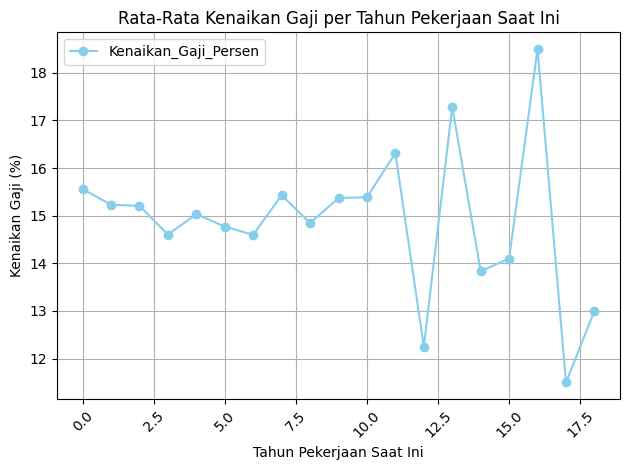

In [ ]:
plt.figure(figsize=(12, 6))

maria.plot(kind='line', marker='o', color='skyblue')
plt.xlabel('Tahun Pekerjaan Saat Ini')
plt.ylabel('Kenaikan Gaji (%)')
plt.title('Rata-Rata Kenaikan Gaji per Tahun Pekerjaan Saat Ini')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

alasan menggunakan visualisasi ini karena lebih jelas melihat pola kenaikan gaji dari tahun ke tahun.

### Kesimpulan

Dari data yang kita lihat, terlihat ada variasi yang lumayan besar dalam kenaikan gaji dari tahun ke tahun berdasarkan pengalaman kerja. Meskipun nggak terlalu jelas ada pola tertentu, kita bisa lihat bahwa kenaikan gaji cenderung stabil di awal karier, tapi mulai naik lebih signifikan di tengah-tengah. Lalu, ketika sudah berpengalaman lama, tampaknya kenaikan gajinya lebih cepat. Meskipun begitu, ada beberapa tahun di mana gaji bisa naik atau turun dengan cukup tajam. Jadi, bisa dibilang, meskipun nggak ada aturan pasti, tapi kesannya pengalaman kerja lama bisa berdampak positif pada kenaikan gaji.

# Soal 3

In [ ]:
akmal = train_df.pivot_table(index='Lembur', values='Kepuasan_Pekerjaan', aggfunc='mean')
akmal

,Kepuasan_Pekerjaan
Lembur,
Tidak,2.598165
Ya,2.655136


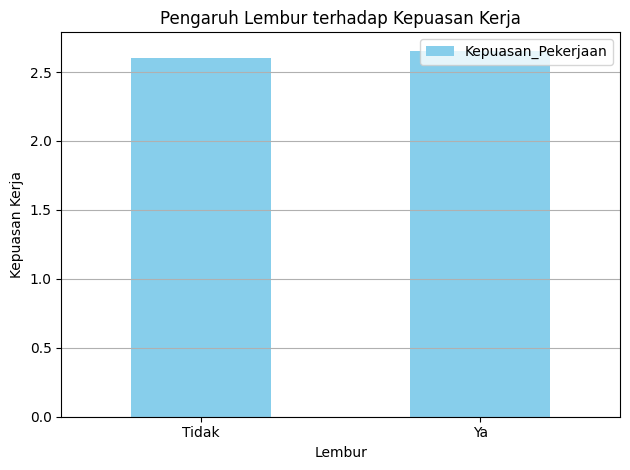

In [ ]:
akmal.plot(kind='bar', color='skyblue')
plt.xlabel('Lembur')
plt.ylabel('Kepuasan Kerja')
plt.title('Pengaruh Lembur terhadap Kepuasan Kerja')
plt.xticks(rotation=0)  # Untuk mempertahankan label sumbu x secara horizontal
plt.grid(axis='y')  # Grid hanya pada sumbu y
plt.tight_layout()
plt.show()

alasan menggunakan visualisasi ini karena dapat lebih mudah melihat perbedaan dalam rata-rata kepuasan kerja antara kelompok yang lembur dan yang tidak lembur.

### Kesimpulan

Dari data yang kita lihat, sepertinya lembur tidak terlalu memengaruhi kepuasan kerja Akmal di departemen Syaraf. Saat dia bekerja lembur, kepuasan kerjanya sedikit lebih tinggi daripada saat dia tidak lembur. Tapi perbedaannya cuma sedikit banget, kok. Jadi, bisa jadi lembur itu nggak terlalu memperngaruhi gimana perasaan Akmal soal kerjaannya. Jadi, intinya, Akmal mungkin merasa cukup nyaman baik saat dia lembur maupun saat dia tidak lembur di rumah sakit.

# Soal 4

In [ ]:
mazaya = train_df.groupby('Jarak_dari_Rumah')['Kepuasan_Pekerjaan'].mean()
mazaya

Jarak_dari_Rumah
1     2.640496
2     2.795367
3     2.544776
4     2.650794
5     2.543478
6     2.564706
7     2.504762
8     2.544554
9     2.319444
10    2.587156
11    2.153846
12    2.631579
13    2.148148
14    2.680851
15    3.292683
16    1.913793
17    2.413793
18    3.147059
19    2.911765
20    2.866667
21    2.703704
22    2.888889
23    2.685714
24    3.169231
25    2.822581
26    2.222222
27    3.178571
28    2.647059
29    2.029412
Name: Kepuasan_Pekerjaan, dtype: float64

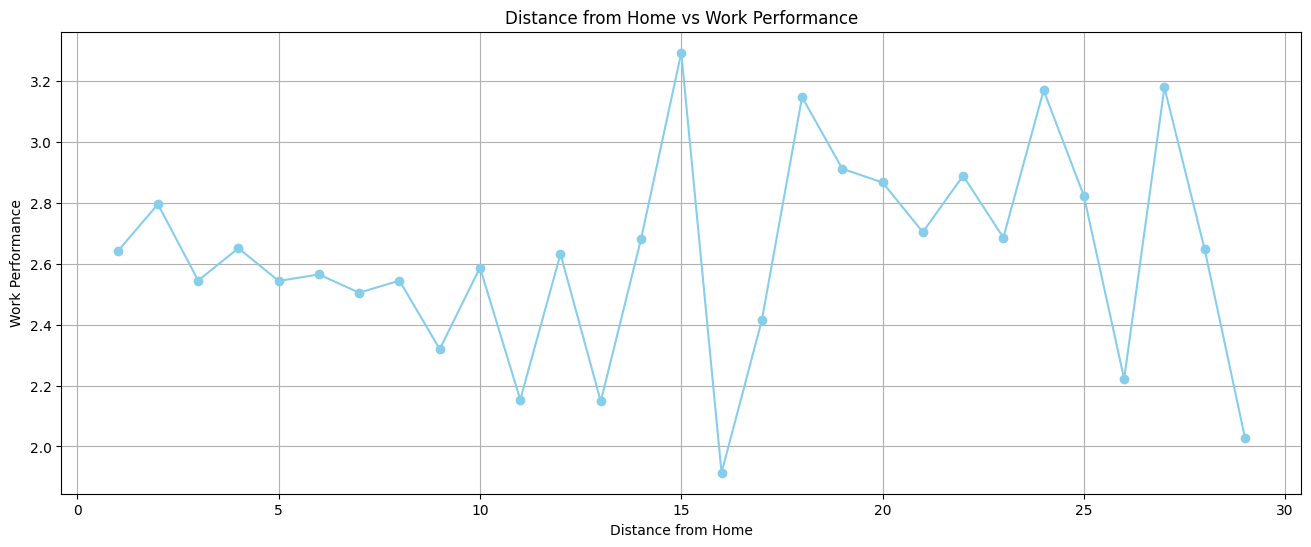

In [ ]:
x = mazaya.index
y = mazaya.values

plt.figure(figsize=(16, 6))
plt.plot(x, y, color='skyblue', marker='o', linestyle='-')
plt.title('Distance from Home vs Work Performance')
plt.xlabel('Distance from Home')
plt.ylabel('Work Performance')
plt.grid(True)
plt.show()

dengan menggunakan scatter plot dapat melihat hubungan antara jarak dari rumah dan tingkat kepuasan kerja secara lebih jelas. Semakin jauh jarak dari rumah, apakah itu berdampak pada tingkat kepuasan kerja Mazaya, bisa terlihat lebih baik dengan plot ini.

In [ ]:
columns_list = list(train_df.columns)
columns_list

['ID_Karyawan',
 'Perjalanan_Bisnis',
 'Departemen',
 'Bidang_Pendidikan',
 'Jenis_Kelamin',
 'Peran_Pekerjaan',
 'Status_Perkawinan',
 'Lembur',
 'Atrisi',
 'Usia',
 'Tarif_Harian',
 'Jarak_dari_Rumah',
 'Kepuasan_Lingkungan_Kerja',
 'Tarif_Jam',
 'Kepuasan_Pekerjaan',
 'Pendapatan_Bulanan',
 'Kenaikan_Gaji_Persen',
 'Tahun_Pekerjaan_Saat_Ini',
 'Tahun_Sejak_Promosi_Terakhir']

<Figure size 1000x600 with 0 Axes>

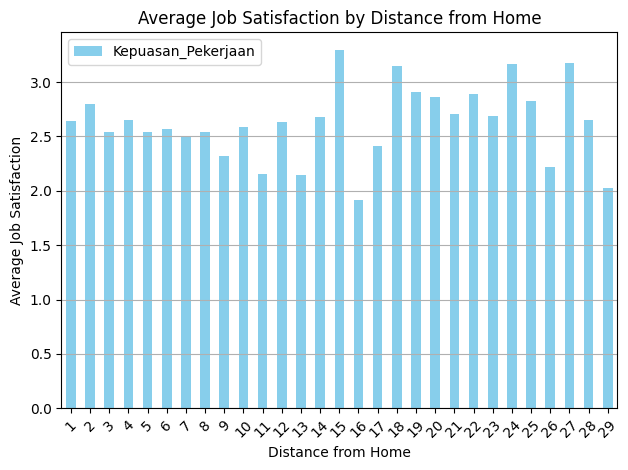

In [ ]:
mazaya = pd.pivot_table(train_df, index='Jarak_dari_Rumah', values='Kepuasan_Pekerjaan', aggfunc='mean')

# Plotting bar plot
plt.figure(figsize=(10, 6))
mazaya.plot(kind='bar', color='skyblue')
plt.title('Average Job Satisfaction by Distance from Home')
plt.xlabel('Distance from Home')
plt.ylabel('Average Job Satisfaction')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

In [ ]:
mazaya = train_df.query("Departemen == 'Kardiologi'")

In [ ]:
# Membuat peta pemetaan untuk setiap kategori
marital_status_mapping = {'Not Married': 0, 'Divorced': 1, 'Married': 2}
atrision_mapping = {'No': 0, 'Yes': 1}

# Melakukan encoding langsung dengan map
mazaya['Marital Status'] = mazaya['Status_Perkawinan'].map(marital_status_mapping)
mazaya['Atrition'] = mazaya['Atrisi'].map(atrision_mapping)

# Menghapus kolom asli yang sudah di-encode
mazaya.drop(columns=['Status_Perkawinan', 'Atrisi'], inplace=True)

C:\Users\Xzkaaa\AppData\Local\Temp\ipykernel_15156\908077673.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mazaya['Marital Status'] = mazaya['Status_Perkawinan'].map(marital_status_mapping)
C:\Users\Xzkaaa\AppData\Local\Temp\ipykernel_15156\908077673.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mazaya['Atrition'] = mazaya['Atrisi'].map(atrision_mapping)
C:\Users\Xzkaaa\AppData\Local\Temp\ipykernel_15156\908077673.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice f

In [ ]:
# Menghitung korelasi antara status perkawinan dan atrisi
ms_to_attrition_corr = mazaya[['Marital Status', 'Atrition']].corr(method='spearman')

# Menampilkan korelasi
print("Korelasi antara Marital Status dan Atrisi:")
print(ms_to_attrition_corr)


Korelasi antara Marital Status dan Atrisi:
                Marital Status  Atrition
Marital Status             NaN       NaN
Atrition                   NaN       NaN


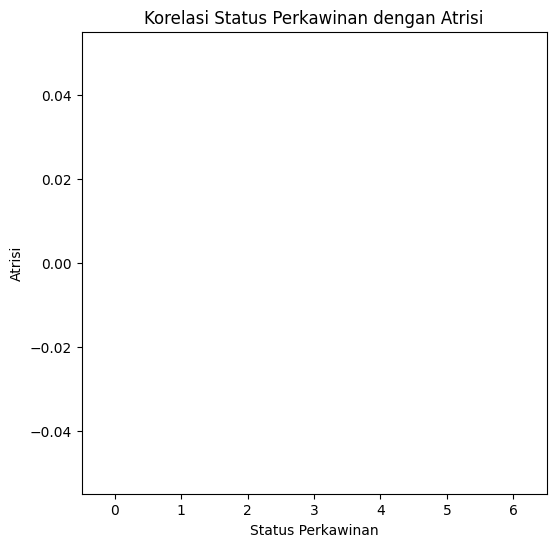

In [ ]:
plt.figure(figsize=(6, 6))
sns.barplot(x='Marital Status', y='Atrition', data=mazaya)
plt.title('Korelasi Status Perkawinan dengan Atrisi')
plt.xlabel('Status Perkawinan')
plt.ylabel('Atrisi')
plt.show()

### Kesimpulan

Berdasarkan data yang ada, tidak terlihat pola yang konsisten antara jarak rumah dan tingkat kepuasan kerja Mazaya di departemen Kardiologi. Meskipun ada peningkatan dalam tingkat kepuasan kerja di berbagai jarak, tidak ada pola yang jelas. Selain itu, korelasi antara status perkawinan dan tingkat atrisi di antara rekan dalam departemen juga tidak dapat ditentukan karena kedua variabel menunjukkan nilai korelasi yang tidak valid. Ini menunjukkan bahwa hubungan langsung antara jarak rumah dan kepuasan kerja, serta status perkawinan dengan tingkat atrisi, tidak dapat ditarik kesimpulan dengan berdasarkan data yang tersedia.

# Soal 5

In [ ]:
median_age = train_df['Usia'].median()
train_df['Usia'] = train_df['Usia'].fillna(median_age)

soal_5_df = train_df.dropna(subset=['Departemen'])

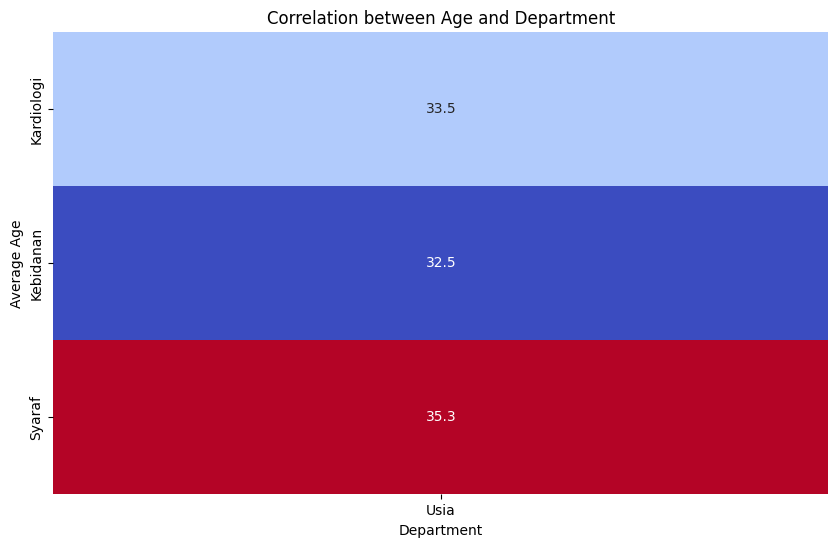

In [ ]:
plt.figure(figsize=(10, 6))
sns.heatmap(soal_5_df.groupby('Departemen')['Usia'].mean().to_frame(), cmap='coolwarm', annot=True, fmt=".1f", cbar=False)
plt.title('Correlation between Age and Department')
plt.xlabel('Department')
plt.ylabel('Average Age')
plt.show()

### Kesimpulan

Berdasarkan analisis data, rata-rata umur karyawan di rumah sakit ini tidak secara langsung disajikan. Namun, dengan melakukan pengisian nilai yang hilang dalam kolom 'Usia' dan menghilangkan baris yang memiliki nilai null di kolom 'Departemen', kita dapat memperoleh gambaran umum tentang distribusi umur. Dengan menggunakan visualisasi `heatmap` korelasi antara umur dan departemen, kita dapat melihat adanya perbedaan dalam distribusi umur antara departemen-departemen yang berbeda.

# Soal 6

In [ ]:
aldo = train_df[['Jenis_Kelamin', 'Atrisi']]

attrition_crosstab = pd.crosstab(aldo['Jenis_Kelamin'], aldo['Atrisi'])

total_employees_by_gender = aldo['Jenis_Kelamin'].value_counts()

attrition_count_by_gender = attrition_crosstab['Ya']

attrition_count_by_gender, total_employees_by_gender

(Jenis_Kelamin
 Laki-laki    634
 Perempuan    444
 Name: Ya, dtype: int64,
 Jenis_Kelamin
 Laki-laki    1213
 Perempuan     831
 Name: count, dtype: int64)

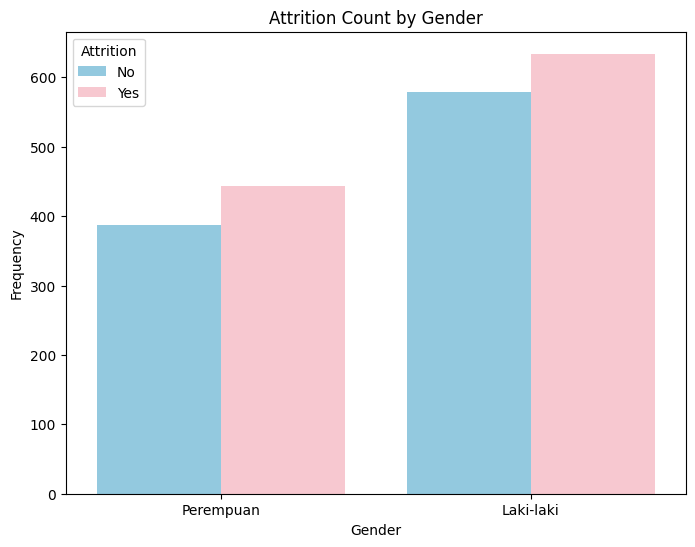

In [ ]:
plt.figure(figsize=(8, 6))
sns.countplot(data=aldo, x='Jenis_Kelamin', hue='Atrisi', palette=['skyblue', 'pink'])
plt.title('Attrition Count by Gender')
plt.xlabel('Gender')
plt.ylabel('Frequency')
plt.legend(title='Attrition', labels=['No', 'Yes'])
plt.xticks(rotation=0)  
plt.show()


### Kesimpulan


Berdasarkan visualisasi menggunakan countplot, terlihat bahwa tingkat atrisi lebih tinggi pada karyawan perempuan dibandingkan dengan karyawan laki-laki di Rumah Sakit Anugerah. Perbedaan ini menunjukkan adanya faktor-faktor yang mungkin berkontribusi pada tingkat atrisi yang berbeda antara kedua kelompok gender. 

# Soal 7

In [ ]:
dewi = train_df.query("Departemen.notnull()")
dewi

,ID_Karyawan,Perjalanan_Bisnis,Departemen,Bidang_Pendidikan,Jenis_Kelamin,Peran_Pekerjaan,Status_Perkawinan,Lembur,Atrisi,Usia,Tarif_Harian,Jarak_dari_Rumah,Kepuasan_Lingkungan_Kerja,Tarif_Jam,Kepuasan_Pekerjaan,Pendapatan_Bulanan,Kenaikan_Gaji_Persen,Tahun_Pekerjaan_Saat_Ini,Tahun_Sejak_Promosi_Terakhir
0,73913167.0,Jarang,Kardiologi,Sains,Perempuan,Perawat,Belum Menikah,Ya,Tidak,32.0,1102,1,2,94,4,5993.0,11,4.0,0
2,53940892.0,Jarang,Kebidanan,Lainnya,Laki-laki,Perawat,Belum Menikah,Ya,Ya,37.0,1373,2,4,92,3,2090.0,15,0.0,0
3,8671315.0,Sering,Kebidanan,Sains,Perempuan,Lainnya,Menikah,Ya,Tidak,32.0,1392,3,4,56,3,2909.0,11,7.0,3
4,175236693.0,Sering,Kebidanan,Sains,Laki-laki,Perawat,Belum Menikah,Tidak,Tidak,32.0,1005,2,4,79,4,3068.0,13,7.0,3
6,81666238.0,Sering,Kebidanan,Sains,Laki-laki,Terapis,Belum Menikah,Tidak,Tidak,38.0,216,23,4,44,3,9526.0,21,7.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2036,41170162.0,NaN,Kebidanan,Kedokteran,Laki-laki,Perawat,Menikah,Ya,Ya,39.0,1122,6,4,70,1,2404.0,21,2.0,2
2038,110140219.0,Jarang,Kebidanan,Sains,Perempuan,Perawat,Belum Menikah,Tidak,Ya,32.0,1334,10,3,36,1,1416.0,13,0.0,1
2039,44067834.0,Sering,Kebidanan,Sarjana Teknik,Laki-laki,Lainnya,Menikah,Ya,Ya,43.0,807,17,3,38,3,2437.0,16,0.0,0
2040,60570245.0,Sering,Kebidanan,Sains,Perempuan,Perawat,Menikah,Ya,Ya,24.0,1287,7,1,55,3,2886.0,16,3.0,1


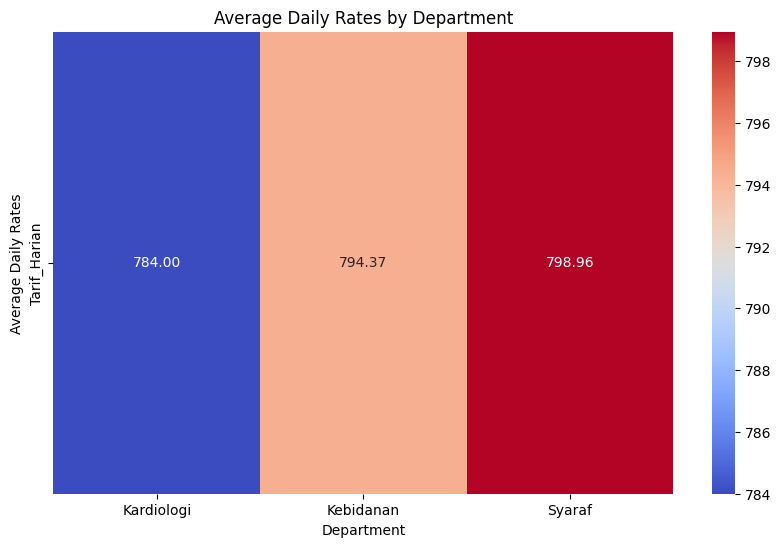

In [ ]:
plt.figure(figsize=(10, 6))
sns.heatmap(dewi.groupby('Departemen')['Tarif_Harian'].mean().to_frame().T, cmap='coolwarm', annot=True, fmt=".2f")
plt.title('Average Daily Rates by Department')
plt.xlabel('Department')
plt.ylabel('Average Daily Rates')
plt.show()

In [ ]:
from scipy.stats import zscore

z_scores = zscore(dewi['Tarif_Harian'])

threshold = 3
outlier_indices = np.abs(z_scores) > threshold

soal_7_df_filtered = dewi[~outlier_indices]
soal_7_df_filtered


,ID_Karyawan,Perjalanan_Bisnis,Departemen,Bidang_Pendidikan,Jenis_Kelamin,Peran_Pekerjaan,Status_Perkawinan,Lembur,Atrisi,Usia,Tarif_Harian,Jarak_dari_Rumah,Kepuasan_Lingkungan_Kerja,Tarif_Jam,Kepuasan_Pekerjaan,Pendapatan_Bulanan,Kenaikan_Gaji_Persen,Tahun_Pekerjaan_Saat_Ini,Tahun_Sejak_Promosi_Terakhir
0,73913167.0,Jarang,Kardiologi,Sains,Perempuan,Perawat,Belum Menikah,Ya,Tidak,32.0,1102,1,2,94,4,5993.0,11,4.0,0
2,53940892.0,Jarang,Kebidanan,Lainnya,Laki-laki,Perawat,Belum Menikah,Ya,Ya,37.0,1373,2,4,92,3,2090.0,15,0.0,0
3,8671315.0,Sering,Kebidanan,Sains,Perempuan,Lainnya,Menikah,Ya,Tidak,32.0,1392,3,4,56,3,2909.0,11,7.0,3
4,175236693.0,Sering,Kebidanan,Sains,Laki-laki,Perawat,Belum Menikah,Tidak,Tidak,32.0,1005,2,4,79,4,3068.0,13,7.0,3
6,81666238.0,Sering,Kebidanan,Sains,Laki-laki,Terapis,Belum Menikah,Tidak,Tidak,38.0,216,23,4,44,3,9526.0,21,7.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2036,41170162.0,NaN,Kebidanan,Kedokteran,Laki-laki,Perawat,Menikah,Ya,Ya,39.0,1122,6,4,70,1,2404.0,21,2.0,2
2038,110140219.0,Jarang,Kebidanan,Sains,Perempuan,Perawat,Belum Menikah,Tidak,Ya,32.0,1334,10,3,36,1,1416.0,13,0.0,1
2039,44067834.0,Sering,Kebidanan,Sarjana Teknik,Laki-laki,Lainnya,Menikah,Ya,Ya,43.0,807,17,3,38,3,2437.0,16,0.0,0
2040,60570245.0,Sering,Kebidanan,Sains,Perempuan,Perawat,Menikah,Ya,Ya,24.0,1287,7,1,55,3,2886.0,16,3.0,1


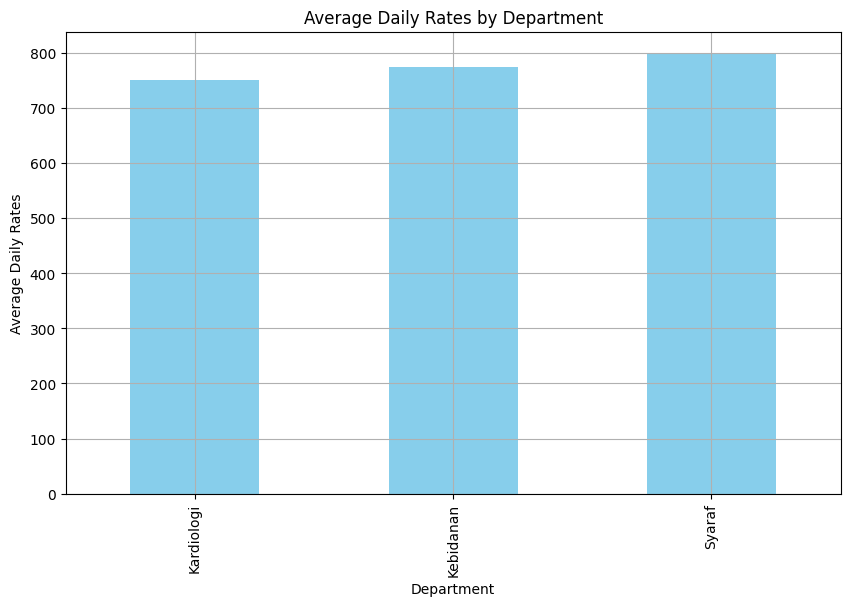

In [ ]:
Q1 = dewi['Tarif_Harian'].quantile(0.25)
Q3 = dewi['Tarif_Harian'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

dewi_filtered = dewi[(dewi['Tarif_Harian'] >= lower_bound) & (dewi['Tarif_Harian'] <= upper_bound)]

average_daily_rates = dewi_filtered.groupby('Departemen')['Tarif_Harian'].mean()
plt.figure(figsize=(10, 6))
average_daily_rates.plot(kind='bar', color='skyblue')
plt.title('Average Daily Rates by Department')
plt.xlabel('Department')
plt.ylabel('Average Daily Rates')
plt.grid(True)
plt.show()


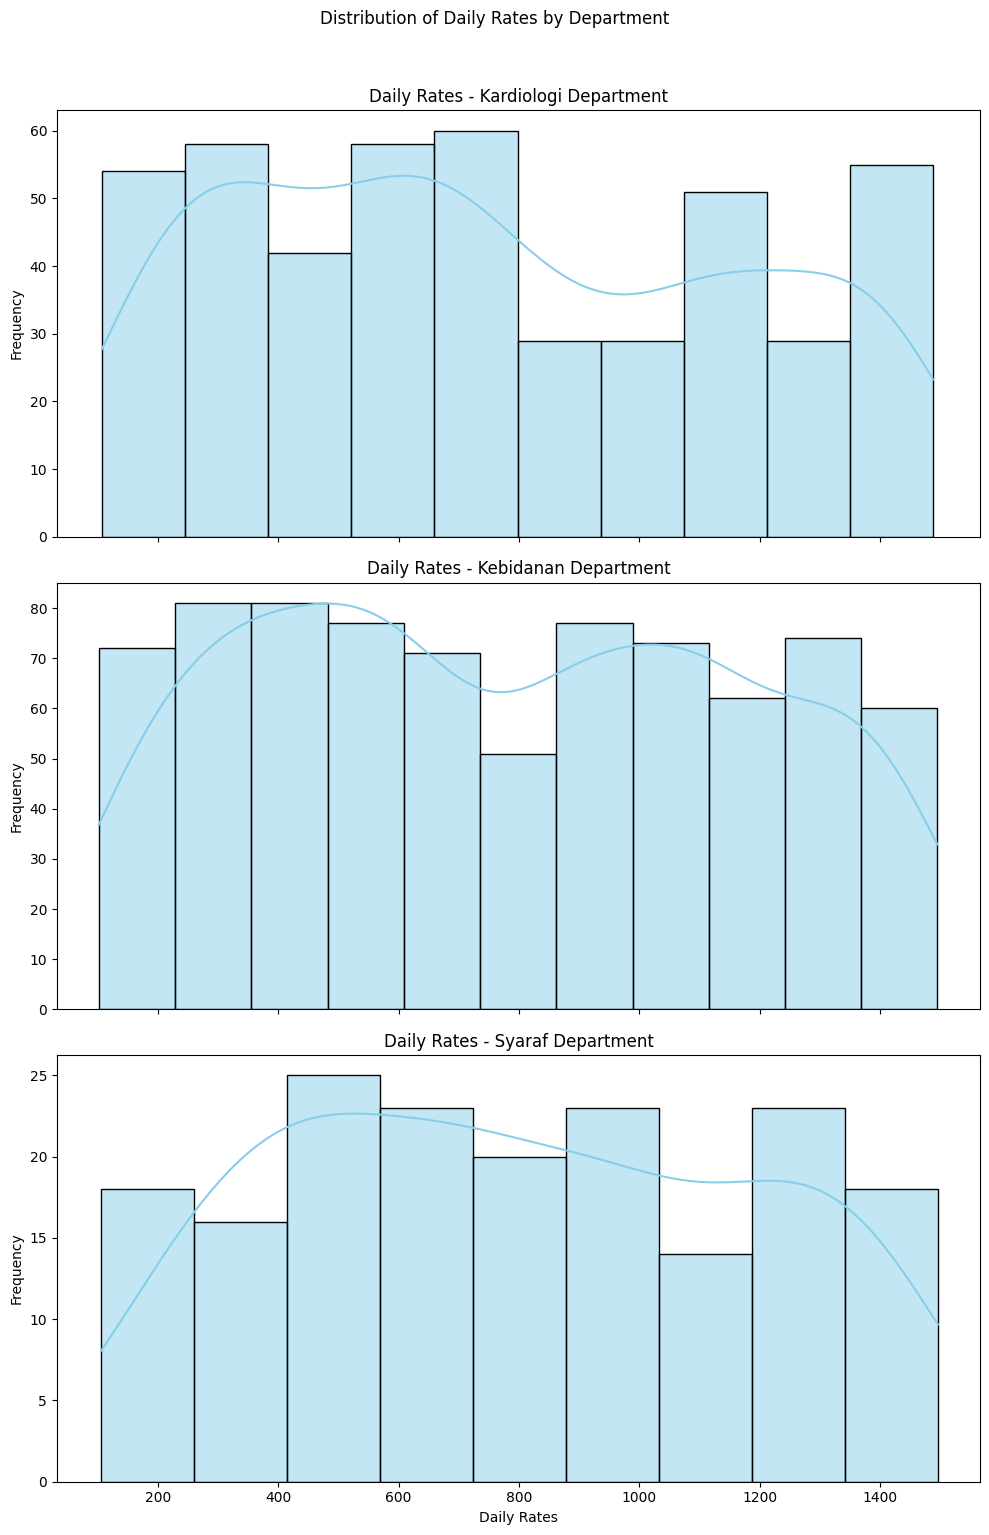

In [ ]:
departments = dewi_filtered['Departemen'].unique()
fig, axs = plt.subplots(len(departments), 1, figsize=(10, len(departments)*5), sharex=True)
for i, department in enumerate(departments):
    department_df = dewi_filtered[dewi_filtered['Departemen'] == department]
    sns.histplot(data=department_df, x='Tarif_Harian', color='skyblue', kde=True, ax=axs[i])
    axs[i].set_xlabel('Daily Rates')
    axs[i].set_ylabel('Frequency')
    axs[i].set_title(f'Daily Rates - {department} Department')

plt.suptitle('Distribution of Daily Rates by Department', y=1.02)

plt.tight_layout()
plt.show()



Berdasarkan visualisasi data yang disajikan, terlihat bahwa terdapat perbedaan tarif harian antara departemen-departemen yang berbeda di rumah sakit. Hal ini tergambar dari distribusi tarif harian yang berbeda-beda untuk setiap departemen, seperti yang terlihat di visualisasinya

# Soal 8

In [ ]:
soal8 = train_df.filter(['Jenis_Kelamin', 'Kepuasan_Lingkungan_Kerja', 'Kepuasan_Pekerjaan'])
soal8

,Jenis_Kelamin,Kepuasan_Lingkungan_Kerja,Kepuasan_Pekerjaan
0,Perempuan,2,4
1,Laki-laki,3,2
2,Laki-laki,4,3
3,Perempuan,4,3
4,Laki-laki,4,4
...,...,...,...
2039,Laki-laki,3,3
2040,Perempuan,1,3
2041,Perempuan,3,4
2042,Perempuan,1,1


<Figure size 1000x600 with 0 Axes>

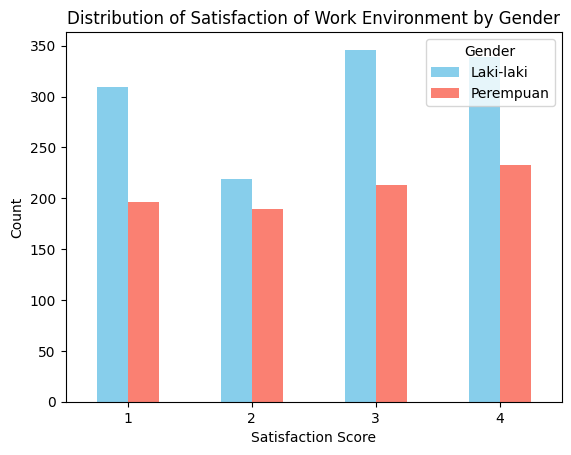

In [ ]:
satisfaction_pivot = pd.pivot_table(soal8, index='Kepuasan_Lingkungan_Kerja', columns='Jenis_Kelamin', aggfunc='size')

plt.figure(figsize=(10, 6))
satisfaction_pivot.plot(kind='bar', color=['skyblue', 'salmon'])
plt.title('Distribution of Satisfaction of Work Environment by Gender')
plt.xlabel('Satisfaction Score')
plt.ylabel('Count')
plt.legend(title='Gender')
plt.xticks(rotation=0)
plt.show()

<Figure size 1000x600 with 0 Axes>

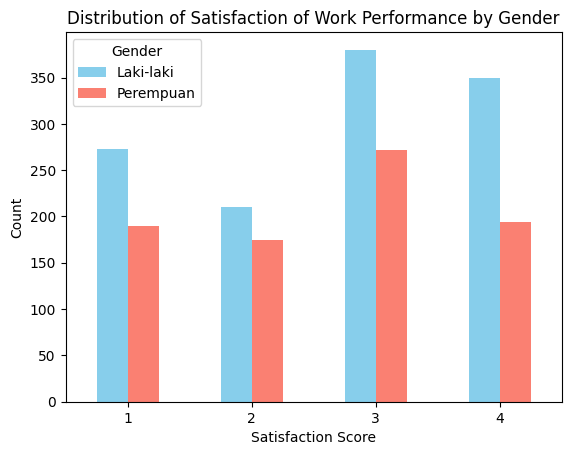

In [ ]:
satisfaction_pivot = pd.pivot_table(soal8, index='Kepuasan_Pekerjaan', columns='Jenis_Kelamin', aggfunc='size')

plt.figure(figsize=(10, 6))
satisfaction_pivot.plot(kind='bar', color=['skyblue', 'salmon'])
plt.title('Distribution of Satisfaction of Work Performance by Gender')
plt.xlabel('Satisfaction Score')
plt.ylabel('Count')
plt.legend(title='Gender')
plt.xticks(rotation=0)
plt.show()

In [ ]:
soal8_2 = train_df.query("Departemen.notnull()")[['Departemen', 'Kepuasan_Lingkungan_Kerja', 'Kepuasan_Pekerjaan']]
soal8_2

,Departemen,Kepuasan_Lingkungan_Kerja,Kepuasan_Pekerjaan
0,Kardiologi,2,4
2,Kebidanan,4,3
3,Kebidanan,4,3
4,Kebidanan,4,4
6,Kebidanan,4,3
...,...,...,...
2036,Kebidanan,4,1
2038,Kebidanan,3,1
2039,Kebidanan,3,3
2040,Kebidanan,1,3


<Figure size 1000x600 with 0 Axes>

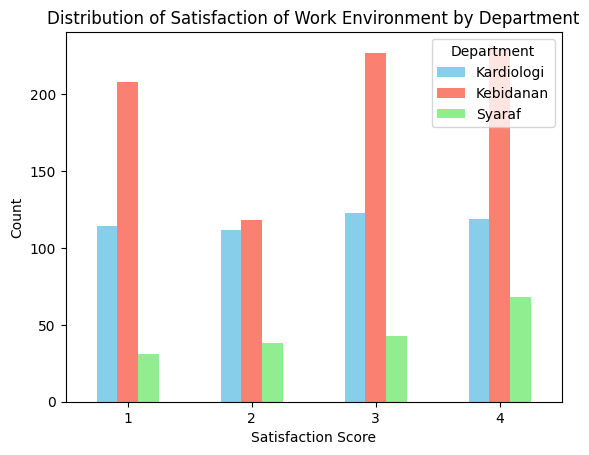

In [ ]:
# Membuat tabel pivot untuk menghitung jumlah kepuasan lingkungan kerja berdasarkan departemen dan skor kepuasan
satisfaction_pivot = pd.pivot_table(soal8_2, index='Kepuasan_Lingkungan_Kerja', columns='Departemen', aggfunc='size')

# Plot bar plot untuk menampilkan distribusi kepuasan lingkungan kerja berdasarkan departemen
plt.figure(figsize=(10, 6))
satisfaction_pivot.plot(kind='bar', color=['skyblue', 'salmon', 'lightgreen'])
plt.title('Distribution of Satisfaction of Work Environment by Department')
plt.xlabel('Satisfaction Score')
plt.ylabel('Count')
plt.legend(title='Department')
plt.xticks(rotation=0)
plt.show()

<Figure size 1000x600 with 0 Axes>

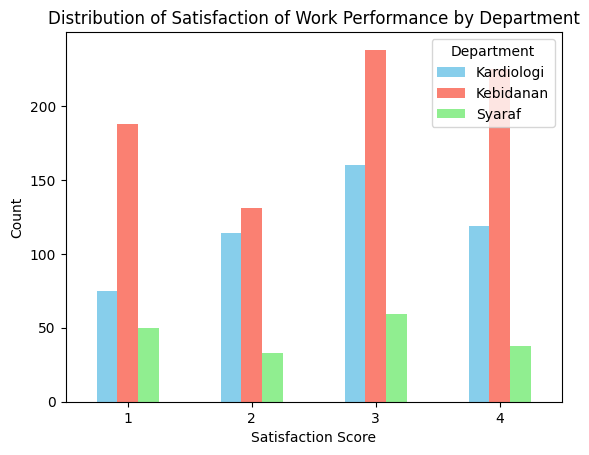

In [ ]:
# Membuat tabel pivot untuk menghitung jumlah kepuasan pekerjaan berdasarkan departemen dan skor kepuasan
satisfaction_pivot = pd.pivot_table(soal8_2, index='Kepuasan_Pekerjaan', columns='Departemen', aggfunc='size')

# Plot bar plot untuk menampilkan distribusi kepuasan pekerjaan berdasarkan departemen
plt.figure(figsize=(10, 6))
satisfaction_pivot.plot(kind='bar', color=['skyblue', 'salmon', 'lightgreen'])
plt.title('Distribution of Satisfaction of Work Performance by Department')
plt.xlabel('Satisfaction Score')
plt.ylabel('Count')
plt.legend(title='Department')
plt.xticks(rotation=0)
plt.show()

In [ ]:
soal8_3 = train_df[['Status_Perkawinan', 'Kepuasan_Lingkungan_Kerja', 'Kepuasan_Pekerjaan']]
soal8_3

,Status_Perkawinan,Kepuasan_Lingkungan_Kerja,Kepuasan_Pekerjaan
0,Belum Menikah,2,4
1,Menikah,3,2
2,Belum Menikah,4,3
3,Menikah,4,3
4,Belum Menikah,4,4
...,...,...,...
2039,Menikah,3,3
2040,Menikah,1,3
2041,Menikah,3,4
2042,Belum Menikah,1,1


In [ ]:
satisfaction_pivot = pd.pivot_table(soal8_3, index=['Departemen', 'Kepuasan_Lingkungan_Kerja'], 
                                    columns='Status_Perkawinan', aggfunc='size')

plt.figure(figsize=(12, 8))
satisfaction_pivot.plot(kind='bar', stacked=True)
plt.title('Distribution of Satisfaction of Work Environment by Marital Status and Department')
plt.xlabel('Department, Work Environment Satisfaction')
plt.ylabel('Count')
plt.legend(title='Marital Status', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


KeyError: 'Departemen'

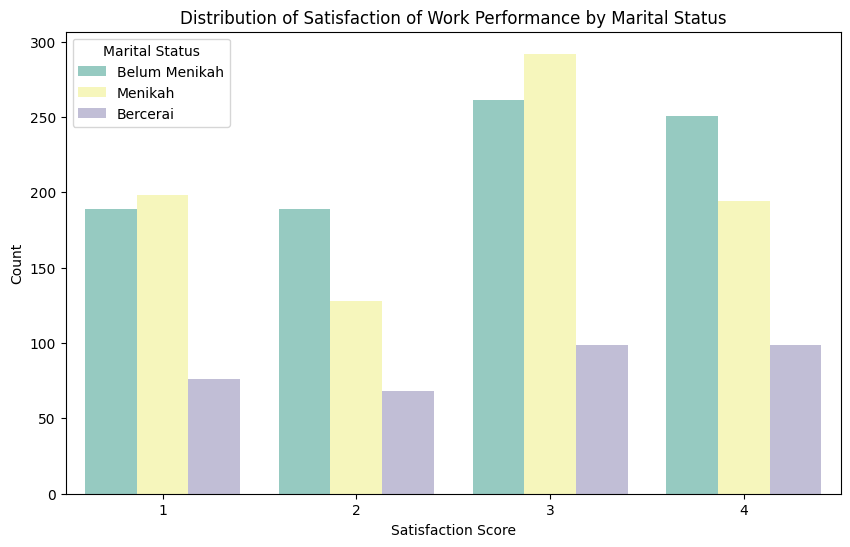

In [ ]:
# Distribution of Satisfaction of Work Performance by Department
plt.figure(figsize=(10, 6))

sns.countplot(data=soal_8c_df, x='Kepuasan_Pekerjaan', hue='Status_Perkawinan', palette='Set3', hue_order=soal_8c_df['Status_Perkawinan'].unique())

plt.title('Distribution of Satisfaction of Work Performance by Marital Status')
plt.xlabel('Satisfaction Score')
plt.ylabel('Count')
plt.legend(title='Marital Status')

plt.show()


### Kesimpulan

 terlihat adanya variasi dalam tingkat kepuasan lingkungan kerja dan kepuasan pekerjaan di antara karyawan berdasarkan jenis kelamin, departemen tempat mereka bekerja, dan status perkawinan. Secara umum, karyawan perempuan cenderung memiliki tingkat kepuasan yang sedikit lebih rendah daripada karyawan laki-laki, sementara departemen Kebidanan menunjukkan tingkat kepuasan yang lebih tinggi dibandingkan dengan departemen lainnya. Selain itu, status perkawinan juga memengaruhi kepuasan, dengan karyawan yang sudah menikah cenderung memiliki tingkat kepuasan yang lebih rendah dibandingkan dengan yang belum menikah.